# Problem 6
A flea starts at $(0,0)$ on the infinite two-dimensional integer lattice and executes a biased random walk: At each step, it hops north or south with probability $\frac{1}{4}$, east with probability $\frac{1}{4} + \epsilon$, and west with probability $ \frac{1}{4} - \epsilon$. The probability that the flea returns to $(0,0)$ sometime during its wanderings is $\frac{1}{2}$. What is $\epsilon$?

Here, we mostly follow the notation and exposition given in Chapter 6 of [Bornemann's book](https://epubs.siam.org/doi/book/10.1137/1.9780898717969)

### Modelling as a Linear System

Let $p_N, p_S, p_E, p_W$ be the probabilities that the flea goes north, south, east, and west respectively, and also define $q(x,y)$ to be the probability that the flea returns to the origin from this point. 

We therefore have that $q(0,0) = 1$ and that the probability that the flea ever returns to the origin is $$ p = p_E q(1,0) + p_W q(-1,0) + p_N q(0,1) + p_S q(0,-1) $$

Conditioning on each direction that the flea can travel, we also have that $q$ satisfies the following linear equation:

$$q(x,y) = p_E q(x+1, y) + p_W q(x-1,y) + p_N q(x,y+1)+ p_S q(x,y-1) $$

Instead of dealing of $q$, we instead approximate it with $\hat{q}(x,y) = \begin{cases} q(x,y) \; \; |x|, |y| < N \\ 0 \; \; \text{otherwise}\end{cases}$

Using the same recurrence, we then get a system of $(2N+1)^2$ linear equations that we can solve for the values of $\hat{q}$

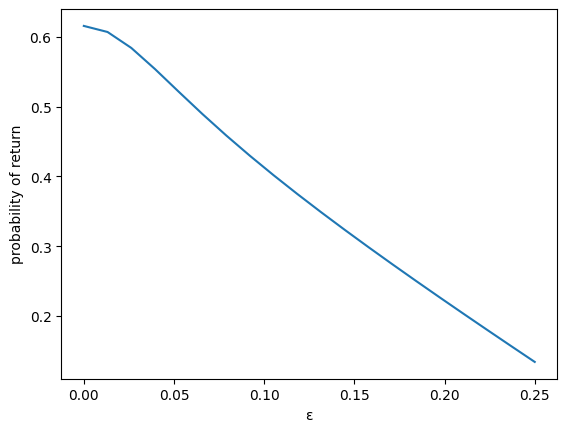

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
from scipy.optimize import bisect

def solve(N, eps):
    pN, pS, pE, pW = 0.25, 0.25, 0.25+eps, 0.25-eps
    pts = [(x,y) for x in range(-N,N+1) for y in range(-N,N+1)]
    # we form a linear equation A x = 0, where x = [q(x_i, y_i)]
    matrix = [] # entries are tuples (i,j,A_ij)
    for i, pt in enumerate(pts):
        if pt == (0,0):
            matrix.append([i,i,1])
        else:
            x,y = pt
            entries = []
            matrix.append((i,i,1))
            for neighbor_pt, prob in zip([(x+1, y), (x-1,y), (x,y+1), (x,y-1)], [pE, pW, pN, pS]):
                if neighbor_pt in pts: matrix.append([i, pts.index(neighbor_pt), -prob])
    matrix = np.array(matrix)
    row, col, data = matrix[:, 0].astype(int), matrix[:, 1].astype(int), matrix[:, 2]
    A = coo_matrix((data, (row,col))).tocsc()
    b = np.array([0]*A.shape[0])
    b[pts.index((0,0))] = 1
    q = spsolve(A,b)
    p = pE*q[pts.index((1,0))] + pW*q[pts.index((-1,0))] + pN*q[pts.index((0,1))] + pS*q[pts.index((0,-1))]
    return p

F = np.vectorize(lambda t: solve(10,t))
X = np.linspace(0, 0.25, 20)
Y = F(X)

import matplotlib.pyplot as plt

plt.plot(X, Y)
plt.xlabel("ε"); plt.ylabel("probability of return")
plt.show()

With this, we get a rough estimate of $ p \approx 0.06 $

### Attempt 2: Combinatorics
We define $ E $ to be the flea's expected number of visits to the origin. Note that 
$$ E = \sum_{k>0} k P(\text{flea returns to origin in k steps}) = \sum_{k=1}^\infty k p^{k-1} (1-p) = \frac{1}{1-p}$$


Next, note that any walk of the flea that returns to the origin has to take an even number of steps. Note also that any such walk of $2k$ steps must have an equal number of steps going north and south as well as an equal number of steps going east and west. Therefore, defining $p_{2k}$ to be the probability that the flea returns to the origin after $2k$ steps, we get

$$p_{2k} = \sum_{j=0}^{k}\binom{2k}{j,j,k-j,k-j} p_{N}^j p_{S}^j p_{E}^{k-j} p_{W}^{k-j} = \sum_{j=0}^k \binom{2k}{k} \binom{k}{j}^2 (p_{E} p_{W})^{k-j} (p_{N} p_{S} )^{j} $$

Finally, note that we can write $$\begin{align}
E &= \sum_{k>0} E(\text{flea returns to origin after 2k steps}) \\
&= \sum_{k=1}^\infty p_{2k} \\
&= \sum_{k=1}^\infty \sum_{j=0}^k \binom{2k}{k} \binom{k}{j}^2 (p_{E} p_{W})^{k-j} (p_{N} p_{S} )^{j}
\end{align}$$. 

Note we have that $p = \frac{1}{2} \implies E = \frac{1}{1-\frac{1}{2}} = 2$, so we can use standard root-finding techniques to find an $\epsilon$ such that $E = 2$

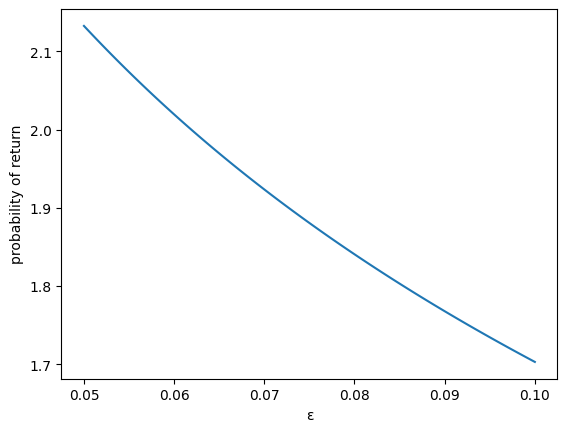

In [2]:
# from math import factorial
import numpy as np
from math import comb as C

def solve2(N, eps):
    pN, pS, pE, pW = 0.25, 0.25, 0.25+eps, 0.25-eps 
    return sum([
        sum([C(2*n, n) * C(n,k)**2 * (pN*pS)**k * (pE*pW)**(n-k) for k in range(n+1)
        ]) for n in range(N)
    ])

F = lambda t: solve2(200, t)
X = np.linspace(0.05, 0.1, 100)
Y = np.vectorize(F)(X)

plt.plot(X, Y)
plt.xlabel("ε"); plt.ylabel("probability of return")
plt.show()

In [3]:
from scipy.optimize import bisect

bisect(lambda eps: solve2(250, eps) - 2, 0.06, 0.062)

0.061912524105980984

With this approach, we are able to get 3 accurate digits. However, this approach has two main issues

 - the sum as is is very costly to compute

In [4]:
%time solve2(250, 0.061912524105980984)

CPU times: user 1.65 s, sys: 3 µs, total: 1.65 s
Wall time: 1.66 s


2.0000000000030997

 - attempting to sum the series to more terms results in an overflow error

In [5]:
solve2(500, 0.061912524105980984)

OverflowError: int too large to convert to float

We bypass both of these issues by evaluating the sum symbolically.

### Attempt 3: Symbolic manipulation

Substituting $x = p_E p_W, y = p_N p_S$, we attempt to evaluate the inner sum symbolically with `sympy`

In [6]:
import sympy

# sympy.init_printing()
x,y = sympy.symbols("x y")
k,j = sympy.symbols("k j", integer=True, positive=True)
sympy.Sum(sympy.binomial(k, j)**2 * x**(k-j) * y**j, (j,0,k)).doit()

x**k*Piecewise((hyper((-k, -k), (1,), y/x), Abs(y/x) <= 1), (Sum(y**j*binomial(k, j)**2/x**j, (j, 0, k)), True))

Therefore, we have that 
$$E =\sum_{k=0}^{\infty}\sum_{j=0}^k \binom{2k}{k} \binom{k}{j}^2 x^{k-j} y^{j} = \sum_{k=0}^{\infty} \binom{2k}{k} x^k {{}_{2}F_{1}\left(\begin{matrix} - k, - k \\ 1 \end{matrix}\middle| {\frac{y}{x}} \right)} $$

where ${}_2F_1$ is the [hypergeometric function](https://en.wikipedia.org/wiki/Hypergeometric_function)

To avoid overflow when calculating the binomial coefficients, we recursively calculate them - defining $a_k = \binom{2k}{k} x^k $, we have $a_0 = 0$ and that $a_k$ satisfies the following recurrence: 

$$\begin{align*}
\frac{a_{k+1}}{a_k} &= \frac{\binom{2k+2}{k+1}x^{k+1}}{\binom{2k}{k}x^k} = \frac{(2k+1)(2k+2)x}{(k+1)^2} \\
&\implies a_{k+1} = a_k \cdot \frac{(2k+1)(2k+2)x}{(k+1)^2} \\
&\iff a_{k} = a_{k-1} \cdot \frac{(2k-1)\cdot2k \cdot x}{k^2}
\end{align*}$$

We thus have the sum is 

$$ E = \sum_{n=0}^\infty a_n \cdot {{}_{2}F_{1}\left(\begin{matrix} - n, - n \\ 1 \end{matrix}\middle| {\frac{y}{x}} \right)} $$

We also use `mpmath` for extended precision

In [7]:
from scipy.special import hyp2f1
from functools import lru_cache
import mpmath

mpmath.mp.dps = 20

def solve3(N, eps):
    pN, pS, pE, pW = 0.25, 0.25, 0.25+eps, 0.25-eps 
    x,y = mpmath.mpf(pE*pW), mpmath.mpf(pN*pS)
    # return x,y
    # Automatically creates cache to store previous values
    @lru_cache(maxsize=None)
    def a(n):
        return 1 if n == 0 else a(n-1) * (2*n-1) * 2*n*x / (n*n)
    return sum([a(n)*mpmath.hyp2f1(-n,-n,1,y/x) for n in range(N)])

%time bisect(lambda t: solve3(2000, t) - 2, 0.0619, 0.062)

CPU times: user 55.5 s, sys: 275 ms, total: 55.7 s
Wall time: 1min


0.06191395447403192

Note that this answer is accurate to more than 10 digits - however we can significantly speed up execution time as follows:

**TODO**: Sage and `sympy` have difficulty with the inner binomial sum; however Mathematica / Wolfram Alpha can [prove](https://www.wolframalpha.com/input?i=sum%28C%28k%2Cj%29%5E2+*+z%5Ej%29+from+j+%3D+0+to+k) that the inner sum can be represented with the [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) $P_n(x)$

$$ \sum_{j=0}^k \binom{k}{j}^2 z^j = (1-z)^k P_k\left(\frac{1+z}{1-z}\right)$$

We have, following [this StackExchange answer](https://math.stackexchange.com/a/766225), that:

$$
\begin{align}
P_n(x) &= \frac{1}{2^n n!}\frac{d^n}{dx^n}\left((x+1)^n\cdot(x-1)^n\right) \\
&= \frac{1}{2^n n!} \sum_{k=0}^n \binom{n}{k} \cdot \left( \frac{d^k}{dx^k}(x+1)^n \right) \cdot \left( \frac{d^{n-k}}{dx^{n-k}} (x-1)^n \right) \\
&= \frac{1}{2^n n!} \sum_{k=0}^n \binom{n}{k} \cdot \frac{n!}{(n-k)!} (x+1)^{n-k} \cdot \frac{n!}{k!} (x-1)^k \\
&= \frac{1}{2^n} \sum_{k=0}^n \binom{n}{k}^2 (x-1)^k (x+1)^{n-k} \\
&= \left(\frac{x+1}{2}\right)^n \sum_{k=0}^n \binom{n}{k}^2 \left(\frac{x-1}{x+1}\right)^k \\
&\implies P\left(\frac{z+1}{z-1}\right) = (1-z)^{-n} \sum_{k=0}^n \binom{n}{k}^2 z^k & \; \left(z \mapsto \frac{x-1}{x+1}\right) \\
&\implies (1-z)^n P\left(\frac{z+1}{z-1}\right) = \sum_{k=0}^n \binom{n}{k}^2 z^k
\end{align}
$$

as desired. Therefore, 

$$ \begin{align*}
E &= \sum_{k=0}^\infty \binom{2k}{k} x^{k} \left[ \sum_{j=0}^k \binom{k}{j}^2 \left(\frac{y}{x}\right)^{j} \right] \\
&= \sum_{k=0}^\infty \binom{2k}{k} x^k (1-y/x)^k P_k\left(\frac{1+y/x}{1-y/x}\right)\\
&= \sum_{k=0}^\infty \binom{2k}{k} (x-y)^k P_k\left(\frac{x+y}{x-y}\right) \\
\end{align*}
$$

Expressing this as a sum of Legendre polynomials, we have the following lemma:

**Lemma (Bornemann p136)**: Let $f(z) = \sum_{k \ge 0} a_k z^k $. Using [Laplace's integral representation of the Legendre polynomials](https://dlmf.nist.gov/18.10#E5), we have

$$\begin{align}
\sum_{k\ge0} a_k P_k(x) z^k &= \sum_{k\ge0} a_k \left( \frac{1}{\pi} \int_0^\pi (x + \sqrt{x^2-1} \cos{\theta})^k d\theta \right) z^k \\
&= \frac{1}{\pi} \int_0^\pi \left( \sum_{k\ge0}a_k (x + \sqrt{x^2-1} \cos{\theta})^k z^k \right) d\theta \\
&= \frac{1}{\pi} \int_0^\pi f\left((x + \sqrt{x^2-1} \cos{\theta})\right) d\theta
\end{align}$$

Using this lemma on the sum, we get the following:

In [8]:
import sympy
from sympy import pi
from sympy.abc import x,y,theta,phi

epsilon = sympy.symbols("epsilon", real = True, positive = True)

u = x+y; Z = x-y
X = u/Z

f = lambda t: 1/sympy.sqrt(1 - 4*t)


I = sympy.collect(f((X + sympy.sqrt(X*X-1) * sympy.cos(theta)) * Z), theta)

# x = pE pW = 1/16 - eps^2 , y = pN pS = 1/16
I = sympy.expand(I.subs({x: sympy.Rational(1,16) - epsilon**2, y: sympy.Rational(1,16)}))

I

1/sqrt(4*epsilon**2*sqrt(-1/(4*epsilon**2) + 1/(64*epsilon**4))*cos(theta) + 4*epsilon**2 + 1/2)

This looks like an [elliptic integral](https://en.wikipedia.org/wiki/Elliptic_integral#Incomplete_elliptic_integral_of_the_first_kind), so we help `sympy` along by rewriting $cos \theta$ in terms of $\phi = \frac{\theta}{2}, d\phi = d\theta / 2$ 

$$ \cos{\theta} = \cos{2 \phi} = 1-2\sin^2{\phi}$$

We thus have:

$$ \frac{1}{\pi} \int_0^\pi f(\cdots) d\theta = \frac{1}{\pi} \int_0^{2\pi} f(\cdots) \frac{d \phi}{2} = \frac{1}{2 \pi} \int_0^{2\pi} f(\cdots) d \phi $$

In [9]:
from IPython.display import display
integral = sympy.integrate(I.subs({sympy.cos(theta): 1 - 2*sympy.sin(phi)**2}), (phi, 0, 2*pi)) / (2*pi)
display(integral)
integral.subs({epsilon: 0.061912524105980984}).n()

2*sqrt(2)*sqrt(epsilon)*elliptic_k(2*epsilon*sqrt(1 - 16*epsilon**2)/(8*epsilon**3 + epsilon*sqrt(1 - 16*epsilon**2) + epsilon))/(pi*sqrt(8*epsilon**3 + epsilon*sqrt(1 - 16*epsilon**2) + epsilon))

2.00001442646520

With this, we are easily able to get over 1000 digits in a few seconds.

In [10]:
import mpmath
mpmath.mp.dps = 1000

f = lambda t: sympy.lambdify(epsilon, integral, "mpmath")(t) - mpmath.mpf('2')

%time mpmath.findroot(f, 0.0619, tol = mpmath.mpf("1e-2000")).real

CPU times: user 294 ms, sys: 12 µs, total: 294 ms
Wall time: 294 ms


mpf('0.061913954473990942848175216473212176999638774998362076061467258859931010297596158459071056457520878613716777621646035477035216576197862389207676926521005424622293646106021983108666450111551444801169054383570823330522355852470934961786758865793202619253229818427553983230659538396699029700379201450293339528637915513428413173819551547081604079876047944966252673904070485709091763645364252758761750193681906643542665130410769275896429379457358898700313736928994949809378129095499896576724082600428539418568068945577099379971491486407704826192633088258890986143363439564532776916252051804392368272972298208515452101842435832391478190169541273221939155167779844724349214183558995839765183920249979972653738590143989976223436830133916972199113886424902119862466074415231148444705871826338018523193263686401419212913361600365581587461876044909569292779809145861570490273592678177710677507510402332276271614015180913219633474323058855433197981726956873468683372361373942097638565039276158405727384083